# Player 1 Binary Win/NotWin classification

In order to show how this can be used as a drop-in replacement, this was taken from https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

It was only modified to load SensorMNIST instead of CIFAR10, removed all comments, and moved to binary classification, and increase the batch size

NOTE: you will have to change the root and subdir paths to make the location of your StarCraftSensor installation

In [4]:
%matplotlib inline

import torch
import torchvision
import torchvision.transforms as transforms

import os, sys
# Load StarCraft2Sensor stuff
ipynb_dir = os.path.dirname(os.path.realpath("__file__"))
model_dir = os.path.join(ipynb_dir, 'models')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
sys.path.append(os.path.join(ipynb_dir, '..'))  # Needed for import below

from sc2sensor.dataset import SensorMNIST
from sc2sensor.dataset import LABELS_DICT, DEFAULT_10
from sc2sensor.utils.image_utils import imshow


root = '/local/scratch/a/shared/starcraft_shared'
subdir = 'starcraft-sensor-dataset'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

def begin_or_end(smd):
    if smd['dynamic.window_percent'] < .50:
        return 'Begining', 0
    else:
        return 'End', 1
    
def target_tran(y):
    return y % 2
        

batch_size = 256

trainset = SensorMNIST(root=root, subdir=subdir, train=True,
                         transform=transform, target_transform=target_tran,
                         label_func=begin_or_end)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=16)

testset = SensorMNIST(root=root, subdir=subdir, train=False,
                        transform=transform, target_transform=target_tran,
                        label_func=begin_or_end)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=16)

#classes = ['-'.join(label) for label in LABELS_DICT[DEFAULT_10]]
classes = ['Begining', 'End']
print(classes)

Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorMNIST_train.npz
Using cached CSV metadata
Using cached data at /local/scratch/a/shared/starcraft_shared/starcraft-sensor-dataset/SensorMNIST_test.npz
['Begining', 'End']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


End   End   Begining Begining


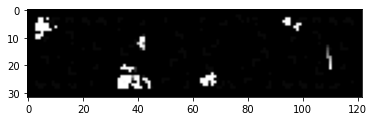

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
# def imshow(img):
#     print(img.min(), img.max())
#     img = img / 2 + 0.5     # unnormalize
#     print(img.min(), img.max())
#     npimg = img.numpy()
#     print(npimg.min(), npimg.max())
#     plt.imshow(np.transpose(npimg, (1, 2, 0)))
#     plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images, labels = images[:min(4, batch_size)], labels[:min(4, batch_size)]

# show images
imshow(torchvision.utils.make_grid(images[:min(4, batch_size)]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(min(4, batch_size))))

In [17]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
net.to(device)
net(images.to(device))

tensor([[ 0.1022, -0.0619],
        [ 0.1039, -0.0631],
        [ 0.1043, -0.0721],
        [ 0.1053, -0.0661],
        [ 0.1041, -0.0710],
        [ 0.1028, -0.0597],
        [ 0.1037, -0.0623],
        [ 0.1050, -0.0614],
        [ 0.1022, -0.0643],
        [ 0.0951, -0.0671],
        [ 0.1023, -0.0659],
        [ 0.1020, -0.0611],
        [ 0.1014, -0.0654],
        [ 0.0988, -0.0747],
        [ 0.1061, -0.0743],
        [ 0.0928, -0.0694],
        [ 0.1085, -0.0675],
        [ 0.0899, -0.0789],
        [ 0.0949, -0.0793],
        [ 0.1036, -0.0634],
        [ 0.1048, -0.0619],
        [ 0.1034, -0.0639],
        [ 0.0861, -0.0608],
        [ 0.0992, -0.0676],
        [ 0.0971, -0.0709],
        [ 0.1051, -0.0638],
        [ 0.0939, -0.0627],
        [ 0.0975, -0.0692],
        [ 0.1016, -0.0693],
        [ 0.1023, -0.0644],
        [ 0.1037, -0.0670],
        [ 0.1000, -0.0609],
        [ 0.0994, -0.0659],
        [ 0.0875, -0.0634],
        [ 0.0981, -0.0630],
        [ 0.1056, -0

In [18]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
import time
start = time.time()
for epoch in range(20):  # loop over the dataset multiple times
    prefix = 'binary-sensor-mnist'
    model_file = os.path.join(model_dir, f'{prefix}-epoch-{epoch+1}.pth')
    next_model_file = os.path.join(model_dir, f'{prefix}-epoch-{epoch+2}.pth')
#     if os.path.exists(next_model_file):
#         print(f'Skipping epoch {epoch+1} since next epoch is saved')
#         continue
#     elif os.path.exists(model_file):
#         net.load_state_dict(torch.load(model_file))
#         print(f'Loaded pretrained model {model_file}')
#         continue
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}, cumulative time: {time.time() - start:.2f}')
            running_loss = 0.0
    # Save model every epoch 
    torch.save(net.state_dict(), model_file)
    print(f'Saved model into {model_file}')

print('Finished Training')

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images.to(device)).cpu()
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.1f} %')

Accuracy of the network on the 10000 test images: 74.3 %


In [21]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images.to(device)).cpu()
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: Begining is 68.0 %
Accuracy for class: End   is 80.8 %
